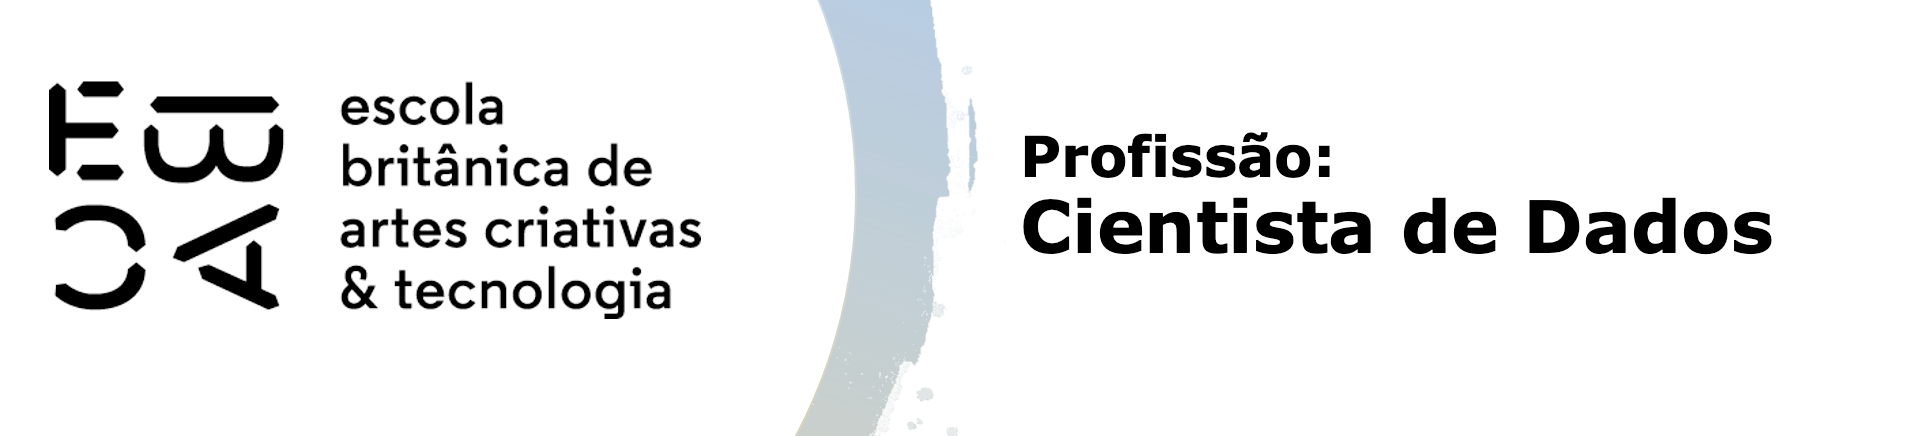

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

from scipy.spatial import distance

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df_og = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df_og.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [4]:
df_og.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
#Não há valores nulos
df_og.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
# Conforme solicitado no comenado do exercício a análise estará fechada nas primeiras seis variáveis da tabela mais a variável resposta.
df = df_og.iloc[:, :6].copy()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 578.1 KB
None


Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  
0                     0.0               1                 0.000000  
1                     0.0               2                64.000000  
2                     0.0               1                 0.000000  
3                     0.0               2                 2.666667  
4                     0.0              10               627.500000

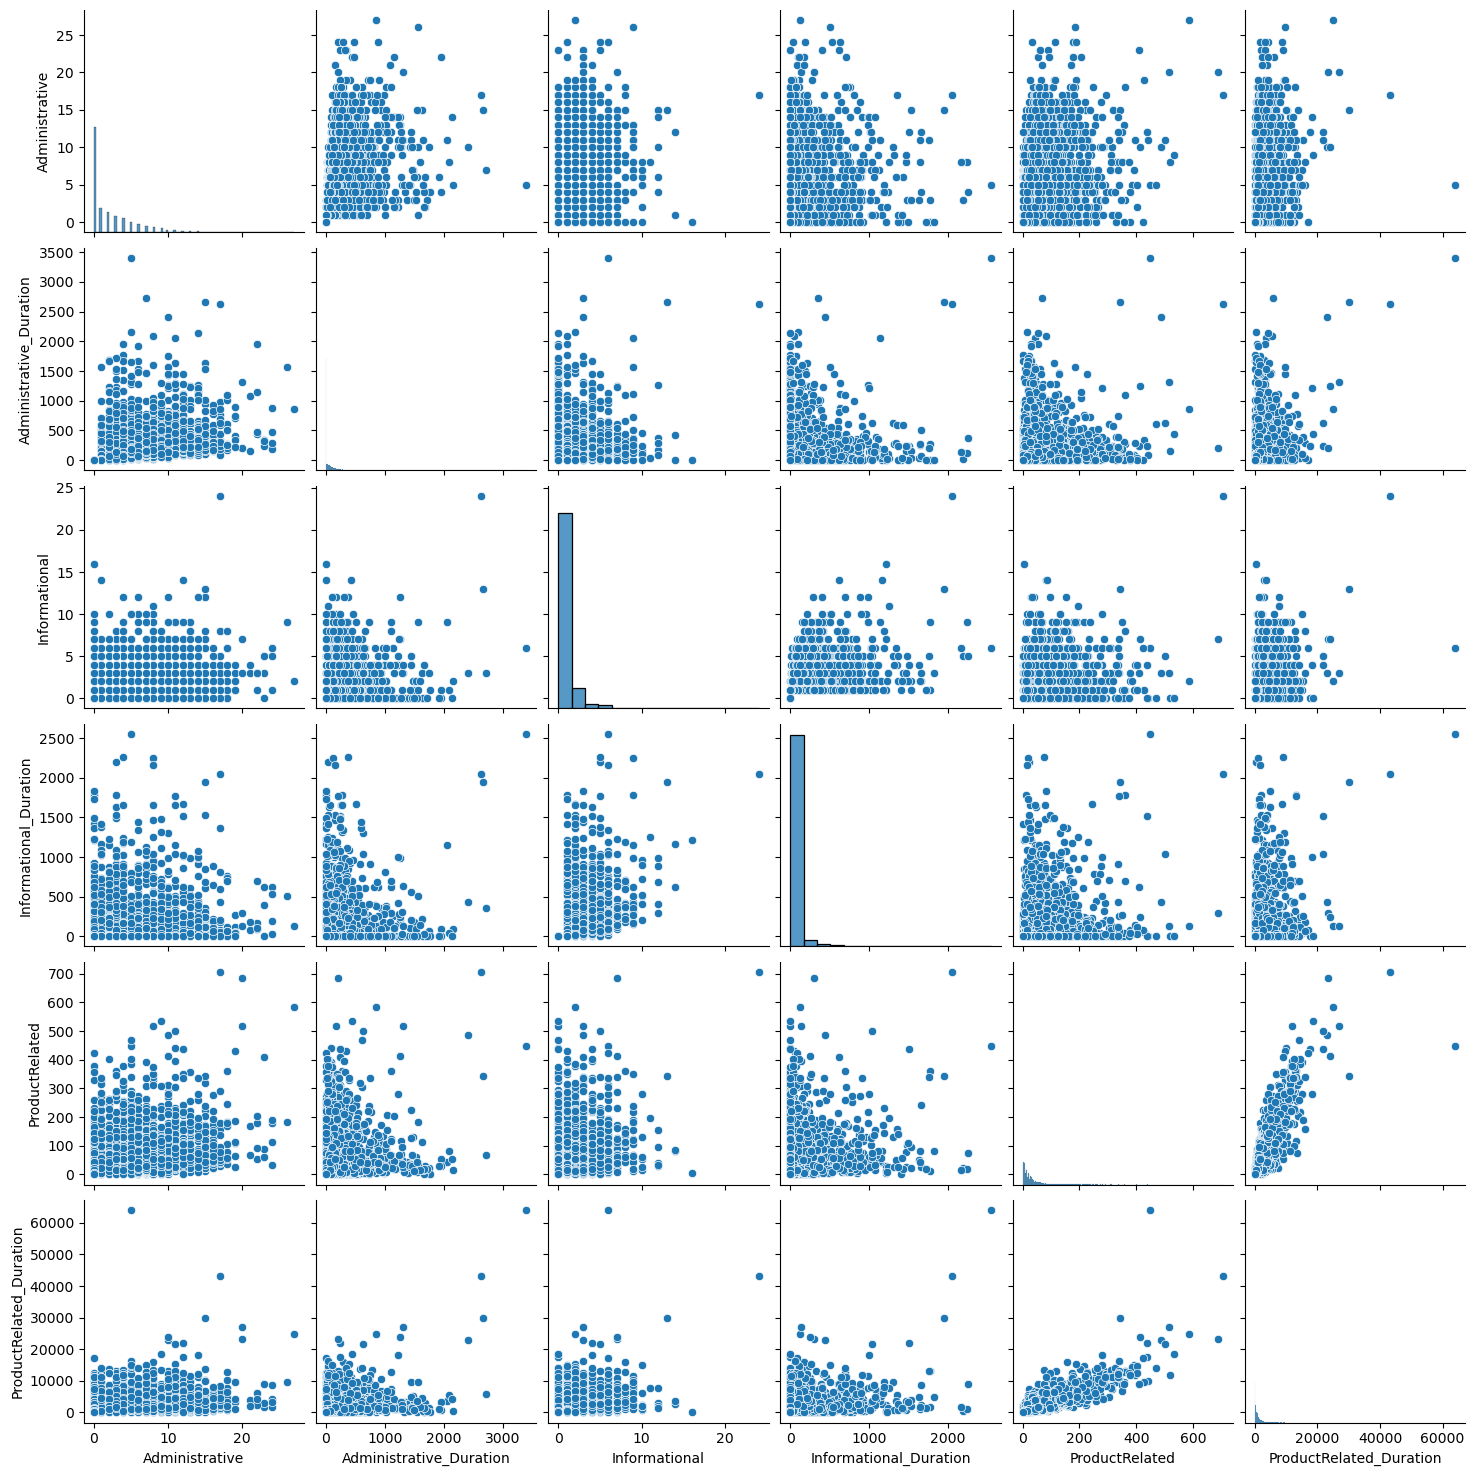

In [8]:
sns.pairplot(df);

Após analisarmos os pairplots, podemos ver que há uma grande variabilidade nos valores de cada coluna. Ou seja, devemos primeiro padronizar os dados para que todas as variáveis fiquem no mesmo patamar.

In [9]:
colunas = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']

padronizador = StandardScaler()
dados_padronizado = padronizador.fit_transform(df)
df_padronizado = pd.DataFrame(dados_padronizado, columns = colunas)
df_padronizado.head()

Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration  
0               -0.244931       -0.691003                -0.624348  
1               -0.244931       -0.668518                -0.590903  
2               -0.244931       -0.691003                -0.624348  
3               -0.244931       -0.668518                -0.622954  
4               -0.244931       -0.488636                -0.296430

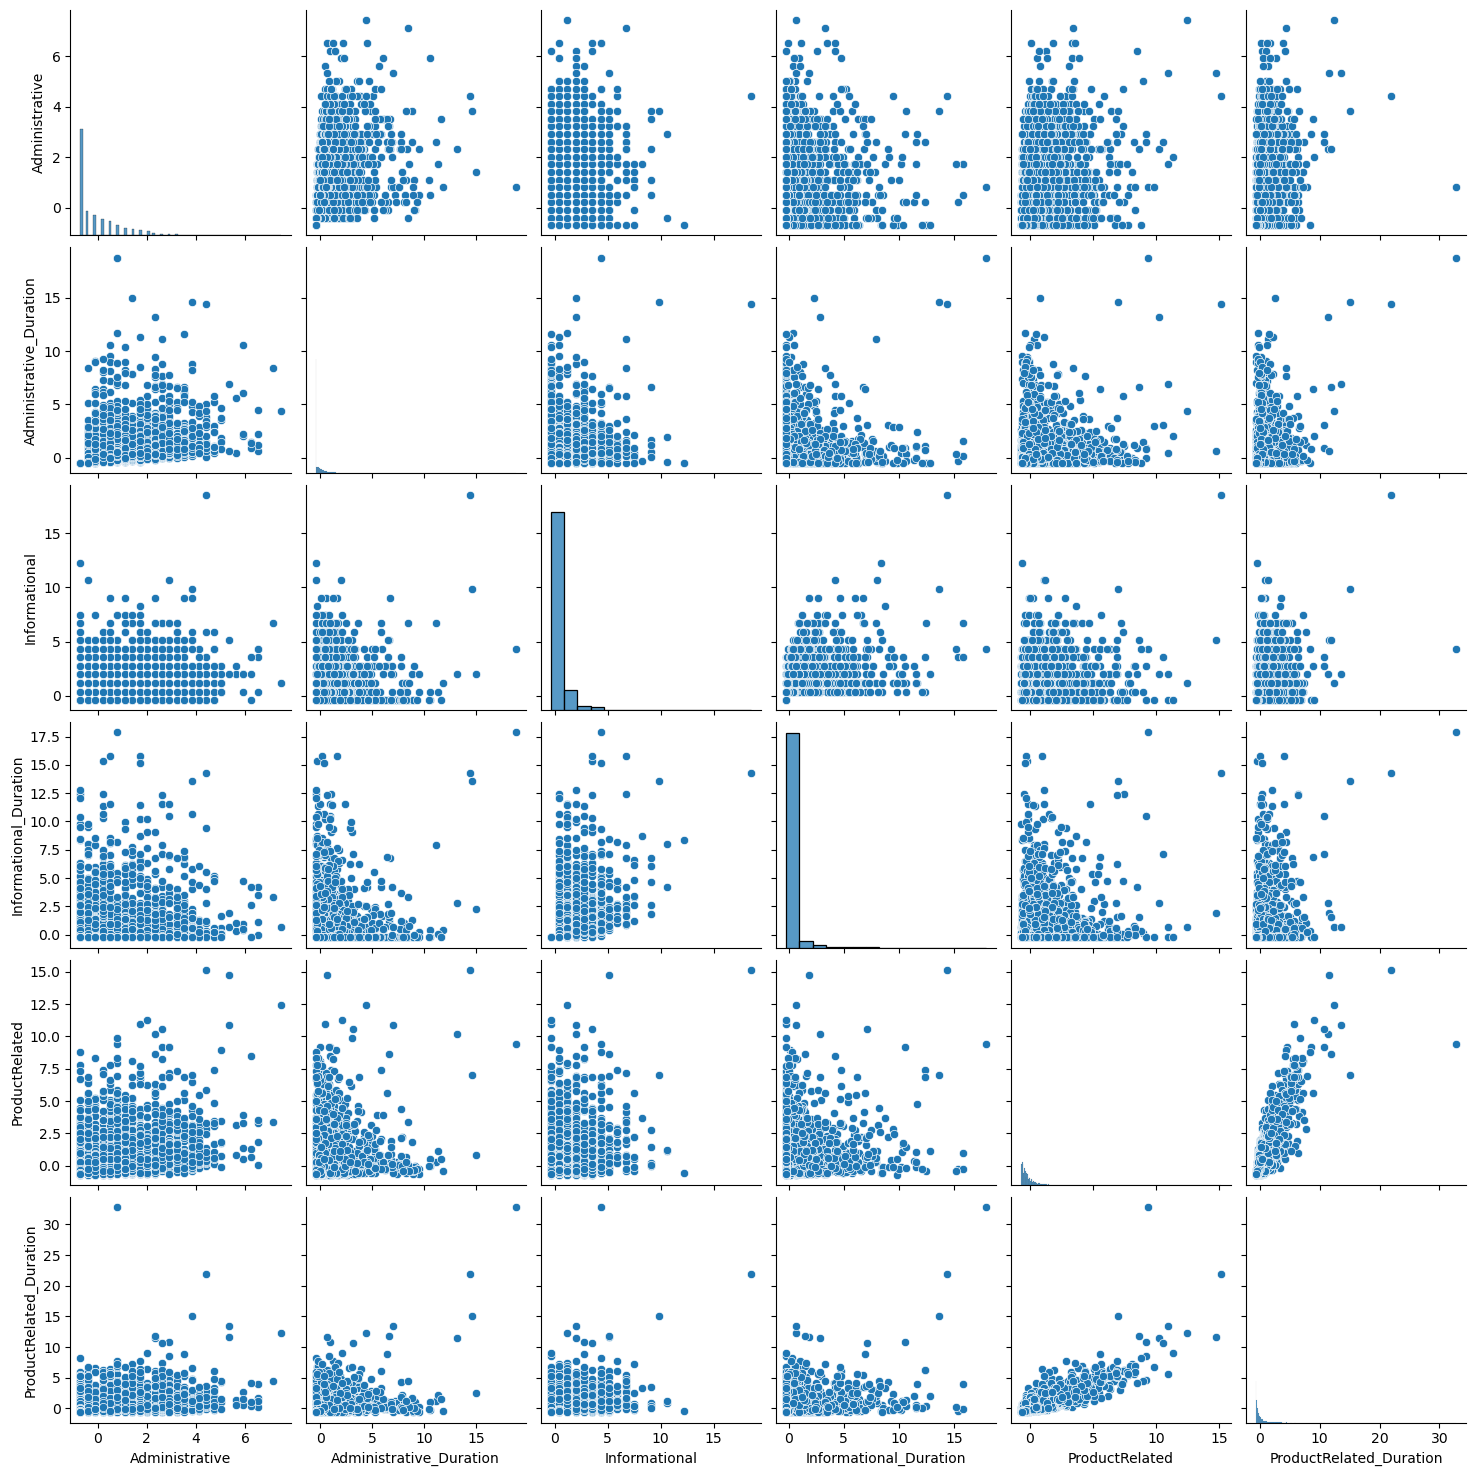

In [10]:
sns.pairplot(df_padronizado);

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

### método do cotovelo (elbow method)

In [11]:
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(df_padronizado[colunas])
    SQD.append(km.inertia_)
SQD

  0%|          | 0/14 [00:00<?, ?it/s]

[73980.00000000003,
 51210.55819891581,
 43201.75551065421,
 37326.366134062395,
 33467.671202929625,
 29688.092304701957,
 26738.101562445536,
 24161.939338652646,
 22497.61795783872,
 21048.87804250024,
 19724.77732631795,
 18848.47129529727,
 18011.73092446821,
 17278.717641197672]

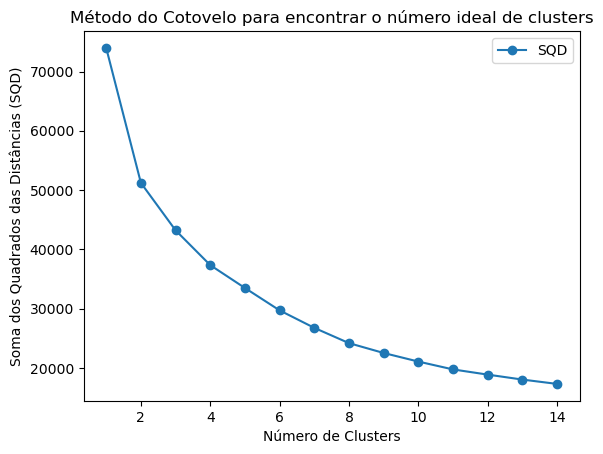

In [12]:
df_cotovelo = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df_cotovelo.plot(x = 'num_clusters', y = 'SQD', marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias (SQD)')
plt.title('Método do Cotovelo para encontrar o número ideal de clusters')
plt.show();

### Coeficiente de Silueta

In [13]:
%%time
# Inicializar uma lista vazia que vai conter os valores da silueta média
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 10

for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(df_padronizado[colunas])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(df_padronizado[colunas], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
    df_padronizado['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)
    
df_padronizado.head()

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 36.1 s
Wall time: 20.3 s


Administrative  Administrative_Duration  Informational  \
0       -0.696993                -0.457191      -0.396478   
1       -0.696993                -0.457191      -0.396478   
2       -0.696993                -0.457191      -0.396478   
3       -0.696993                -0.457191      -0.396478   
4       -0.696993                -0.457191      -0.396478   

   Informational_Duration  ProductRelated  ProductRelated_Duration grupos_2  \
0               -0.244931       -0.691003                -0.624348  grupo_1   
1               -0.244931       -0.668518                -0.590903  grupo_1   
2               -0.244931       -0.691003                -0.624348  grupo_1   
3               -0.244931       -0.668518                -0.622954  grupo_1   
4               -0.244931       -0.488636                -0.296430  grupo_1   

  grupos_3 grupos_4 grupos_5 grupos_6 grupos_7 grupos_8 grupos_9 grupos_10  
0  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   grupo_1  
1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   grupo_1  
2  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   grupo_1  
3  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   grupo_1  
4  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   grupo_1

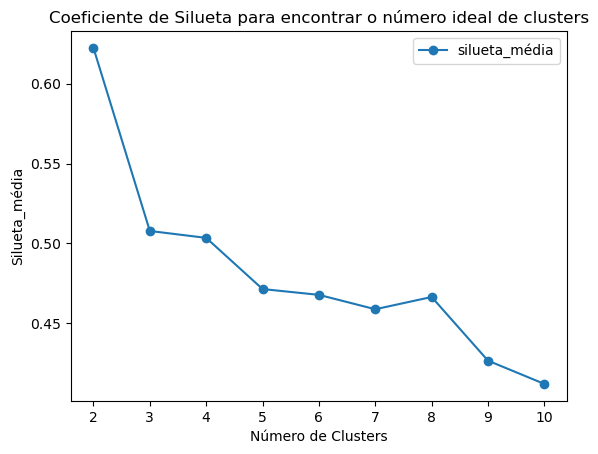

In [14]:
df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})
df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silueta_média')
plt.title('Coeficiente de Silueta para encontrar o número ideal de clusters')
plt.show();

Após análise dos gráficos do método do cotovelo e do coeficiente de silhueta, notamos que o melhor número de clusters seria 2. No entanto, dependendo do negócio, 3 e 4 clusters também poderiam ser interessantes. Visto isso, iremos testar essas três hipóteses e ver qual se encaixa melhor.

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

Incluiremos a variável resposta para plotar gráficos comparativos que nos ajudarão a escolher o número de clusters mais indicado.

In [15]:
df_padronizado['Revenue'] = df_og['Revenue']
df_padronizado

Administrative  Administrative_Duration  Informational  \
0           -0.696993                -0.457191      -0.396478   
1           -0.696993                -0.457191      -0.396478   
2           -0.696993                -0.457191      -0.396478   
3           -0.696993                -0.457191      -0.396478   
4           -0.696993                -0.457191      -0.396478   
...               ...                      ...            ...   
12325        0.206173                 0.363075      -0.396478   
12326       -0.696993                -0.457191      -0.396478   
12327       -0.696993                -0.457191      -0.396478   
12328        0.507228                -0.032916      -0.396478   
12329       -0.696993                -0.457191      -0.396478   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                   -0.244931       -0.691003                -0.624348   
1                   -0.244931       -0.668518                -0.590903   
2                   -0.244931       -0.691003                -0.624348   
3                   -0.244931       -0.668518                -0.622954   
4                   -0.244931       -0.488636                -0.296430   
...                       ...             ...                      ...   
12325               -0.244931        0.478227                 0.307822   
12326               -0.244931       -0.601062                -0.380957   
12327               -0.244931       -0.578577                -0.528063   
12328               -0.244931       -0.376210                -0.443536   
12329               -0.244931       -0.646033                -0.613243   

      grupos_2 grupos_3 grupos_4 grupos_5 grupos_6 grupos_7 grupos_8 grupos_9  \
0      grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
1      grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
2      grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
3      grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
4      grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
12325  grupo_1  grupo_2  grupo_0  grupo_3  grupo_4  grupo_4  grupo_2  grupo_1   
12326  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
12327  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
12328  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_1   
12329  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   

      grupos_10  Revenue  
0       grupo_1    False  
1       grupo_1    False  
2       grupo_1    False  
3       grupo_1    False  
4       grupo_1    False  
...         ...      ...  
12325   grupo_0    False  
12326   grupo_1    False  
12327   grupo_1    False  
12328   grupo_0    False  
12329   grupo_1    False  

[12330 rows x 16 columns]

### 2 Clusters



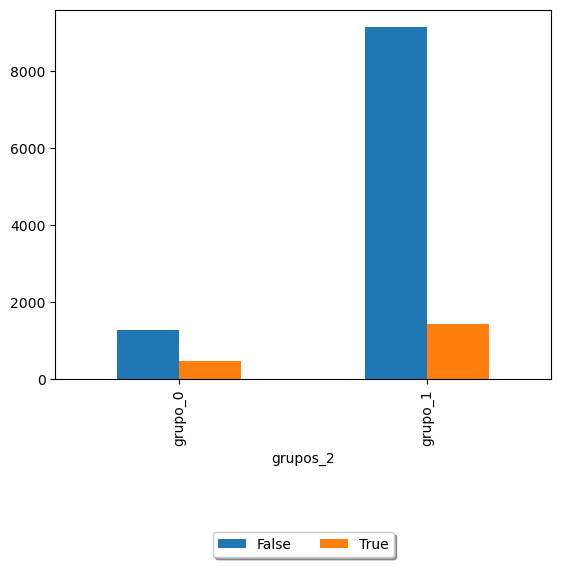

In [17]:
ax = df_padronizado.groupby(['grupos_2', 'Revenue'])['Revenue'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

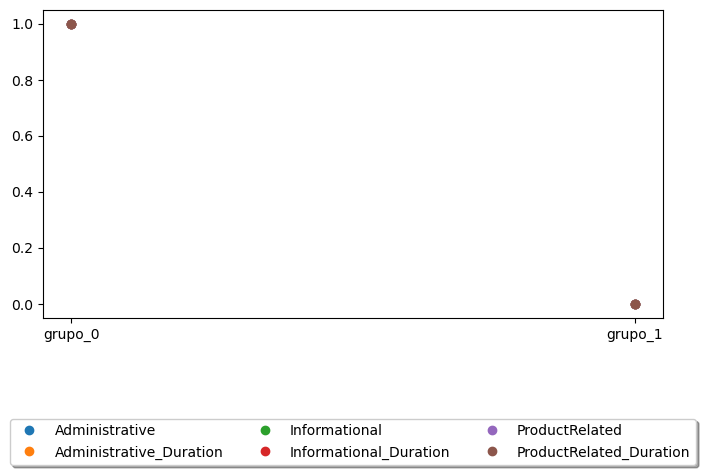

In [18]:
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_padronizado.groupby(['grupos_2'])[colunas].mean().apply(padroniza), 'o ')
ax.legend(colunas, loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True)

In [19]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_2'])

grupos_2  grupo_0  grupo_1
Revenue                   
False        1273     9149
True          479     1429

In [43]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_2'], normalize='columns')

grupos_2   grupo_0   grupo_1
Revenue                     
False     0.726598  0.864908
True      0.273402  0.135092

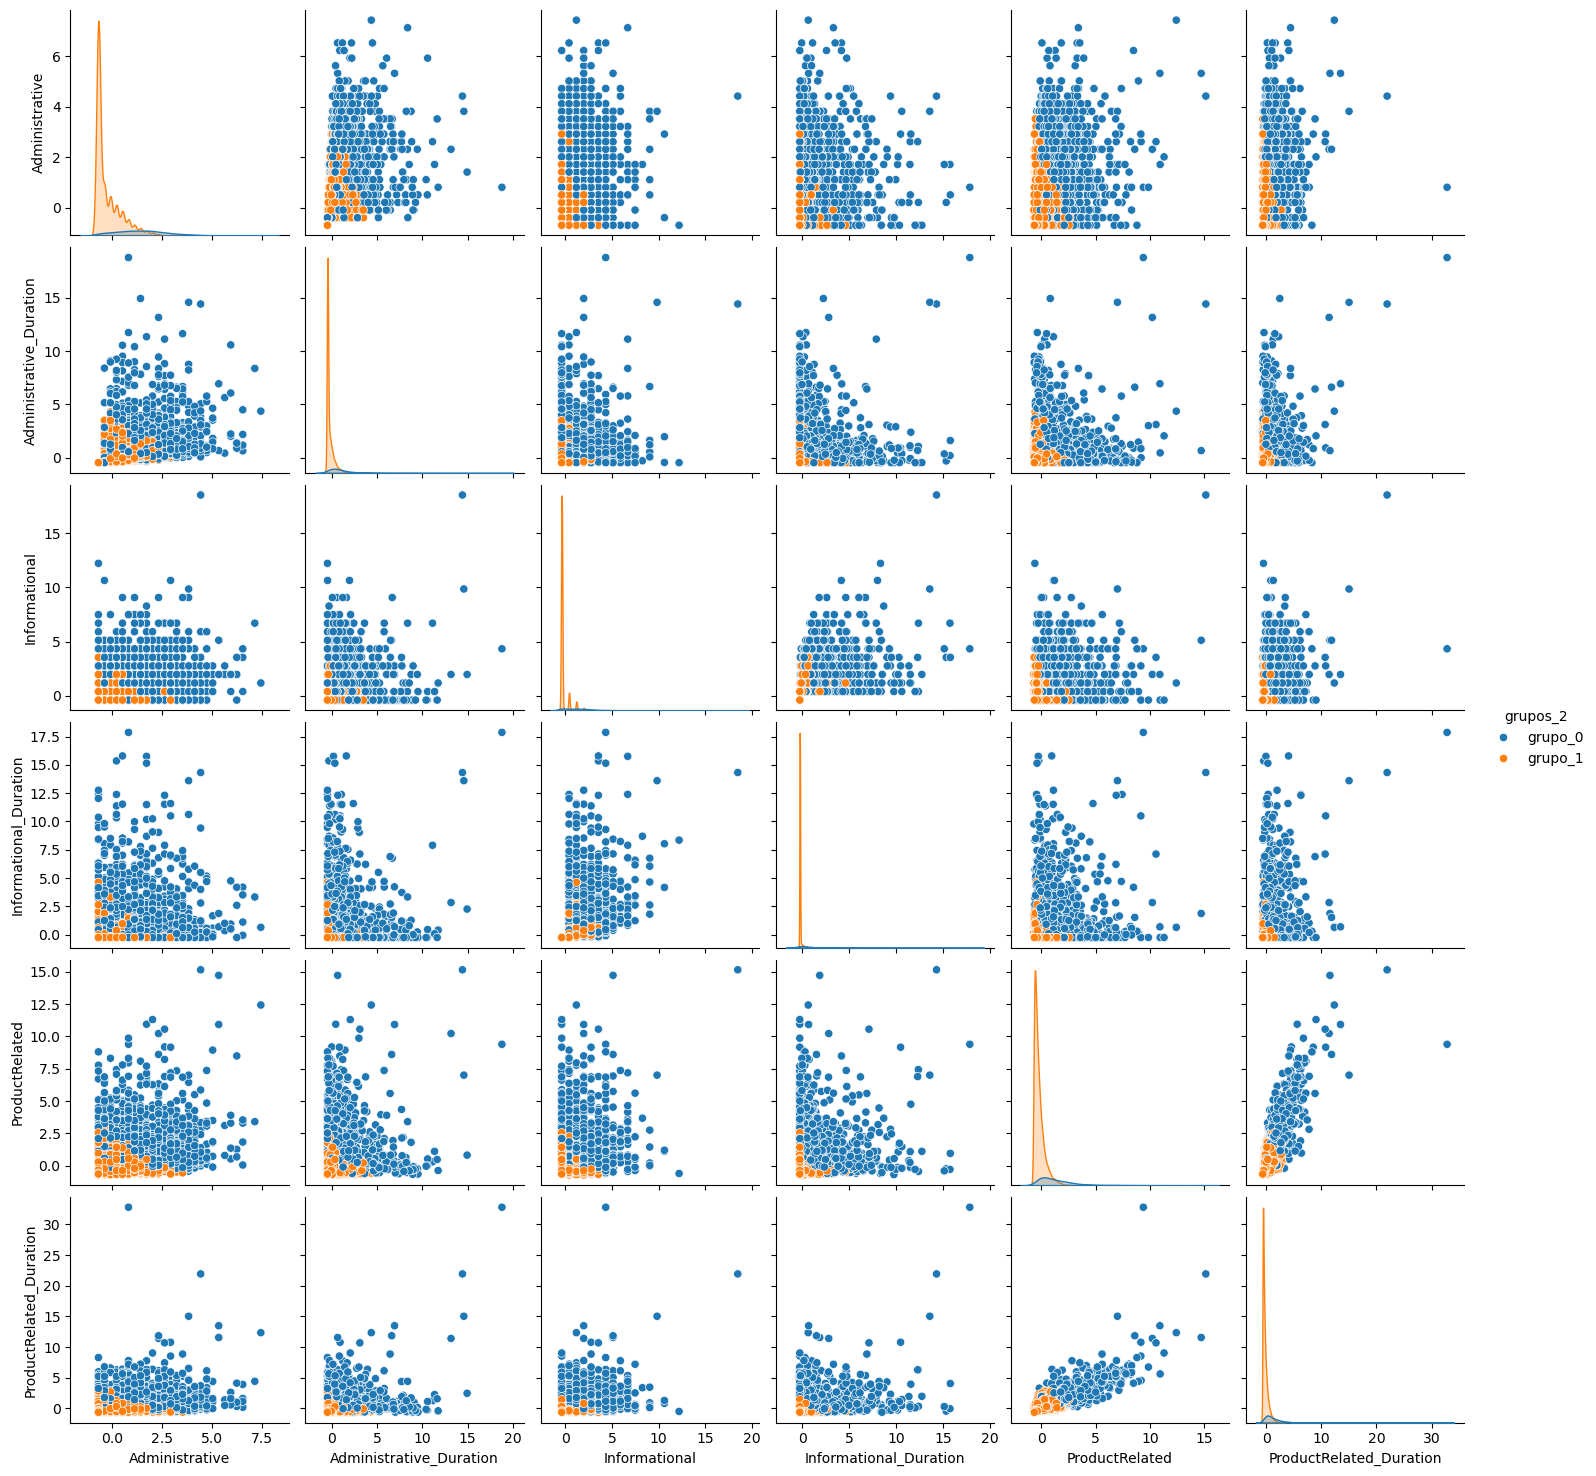

In [21]:
n_clusters = 2
var_grupo = 'grupos_' + str(n_clusters)
sns.pairplot(df_padronizado[colunas + [var_grupo]], hue=var_grupo)

### 3 Clusters

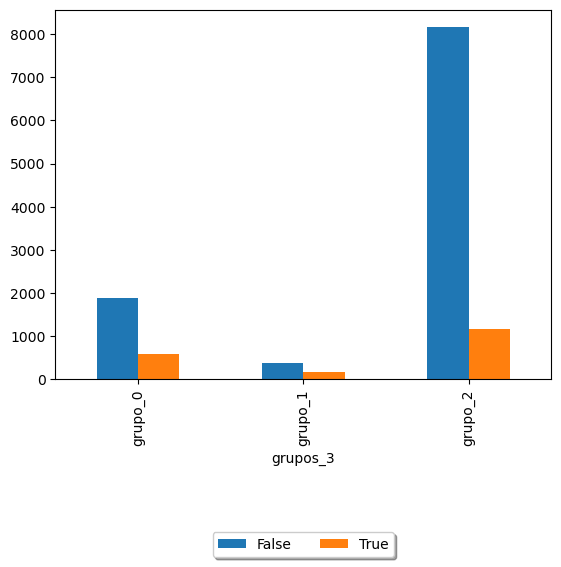

In [22]:
ax = df_padronizado.groupby(['grupos_3', 'Revenue'])['Revenue'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

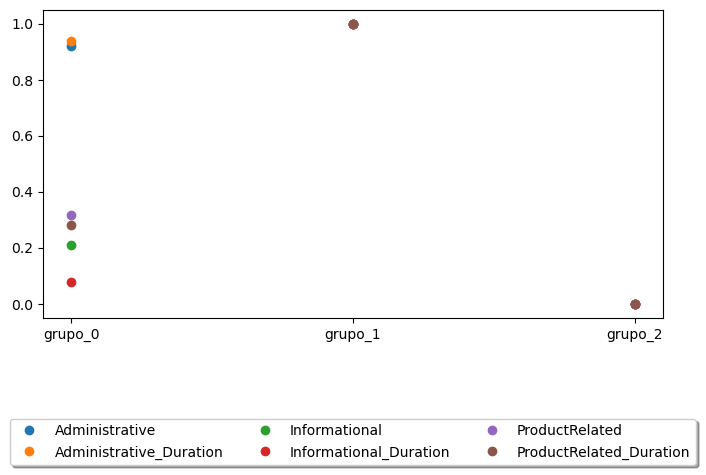

In [31]:
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_padronizado.groupby(['grupos_3'])[colunas].mean().apply(padroniza), 'o ')
ax.legend(colunas, loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True)

In [32]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_3'])

grupos_3  grupo_0  grupo_1  grupo_2
Revenue                            
False        1877      382     8163
True          572      168     1168

In [42]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_3'], normalize='columns')

grupos_3   grupo_0   grupo_1   grupo_2
Revenue                               
False     0.766435  0.694545  0.874826
True      0.233565  0.305455  0.125174

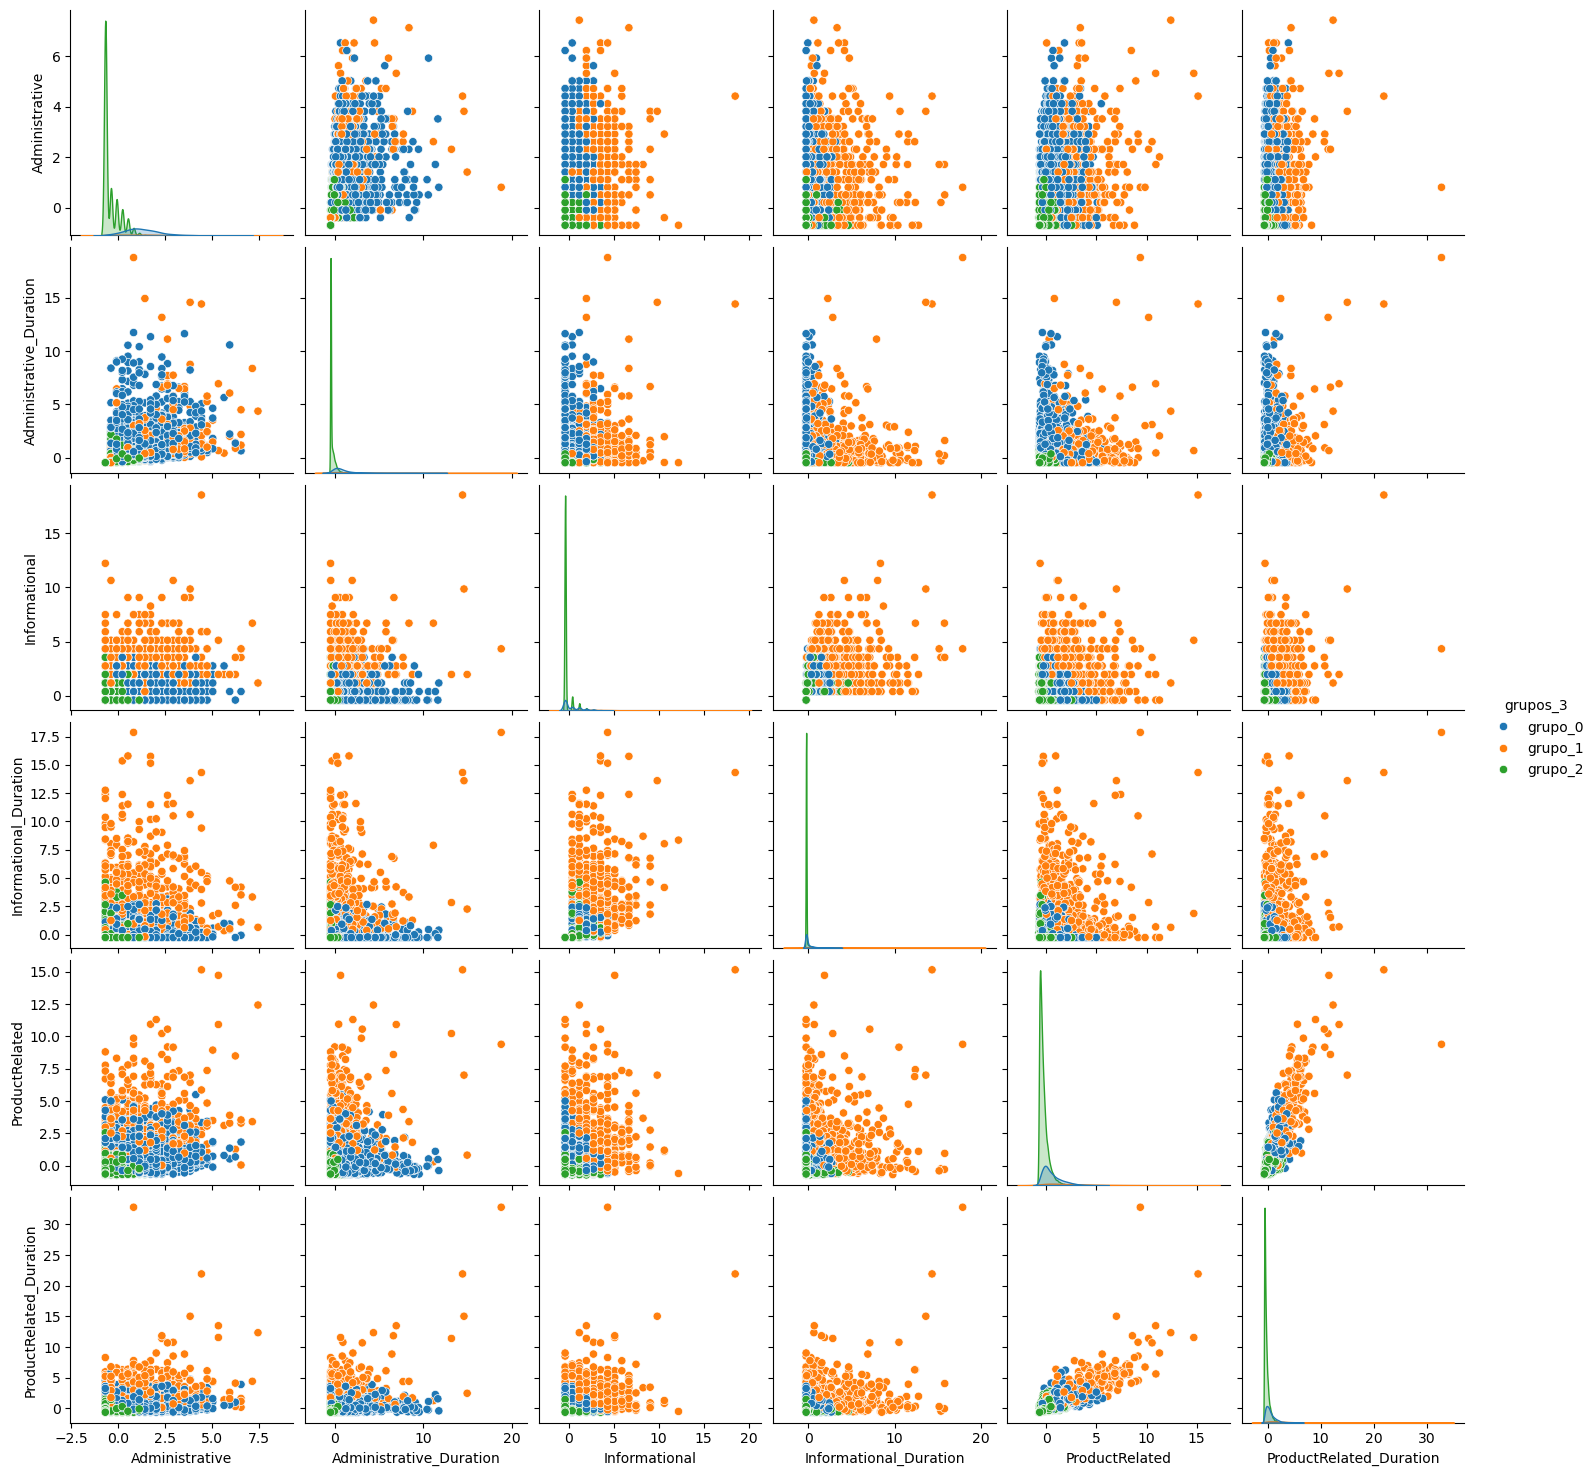

In [33]:
n_clusters = 3
var_grupo = 'grupos_' + str(n_clusters)
sns.pairplot(df_padronizado[colunas + [var_grupo]], hue=var_grupo)

### 4 Clusters

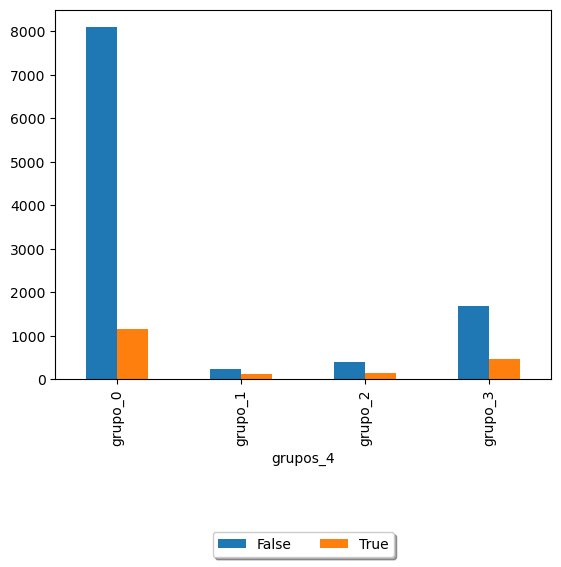

In [34]:
ax = df_padronizado.groupby(['grupos_4', 'Revenue'])['Revenue'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

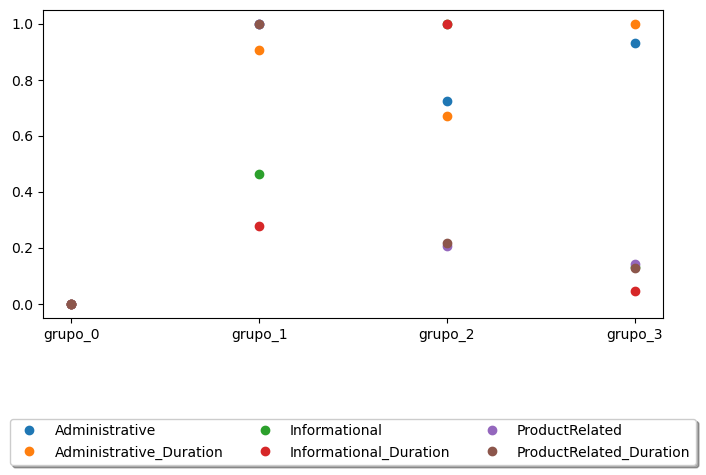

In [35]:
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_padronizado.groupby(['grupos_4'])[colunas].mean().apply(padroniza), 'o ')
ax.legend(colunas, loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True)

In [36]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_4'])

grupos_4  grupo_0  grupo_1  grupo_2  grupo_3
Revenue                                     
False        8091      243      404     1684
True         1161      128      148      471

In [44]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_4'], normalize='columns')

grupos_4   grupo_0   grupo_1   grupo_2   grupo_3
Revenue                                         
False     0.874514  0.654987  0.731884  0.781439
True      0.125486  0.345013  0.268116  0.218561

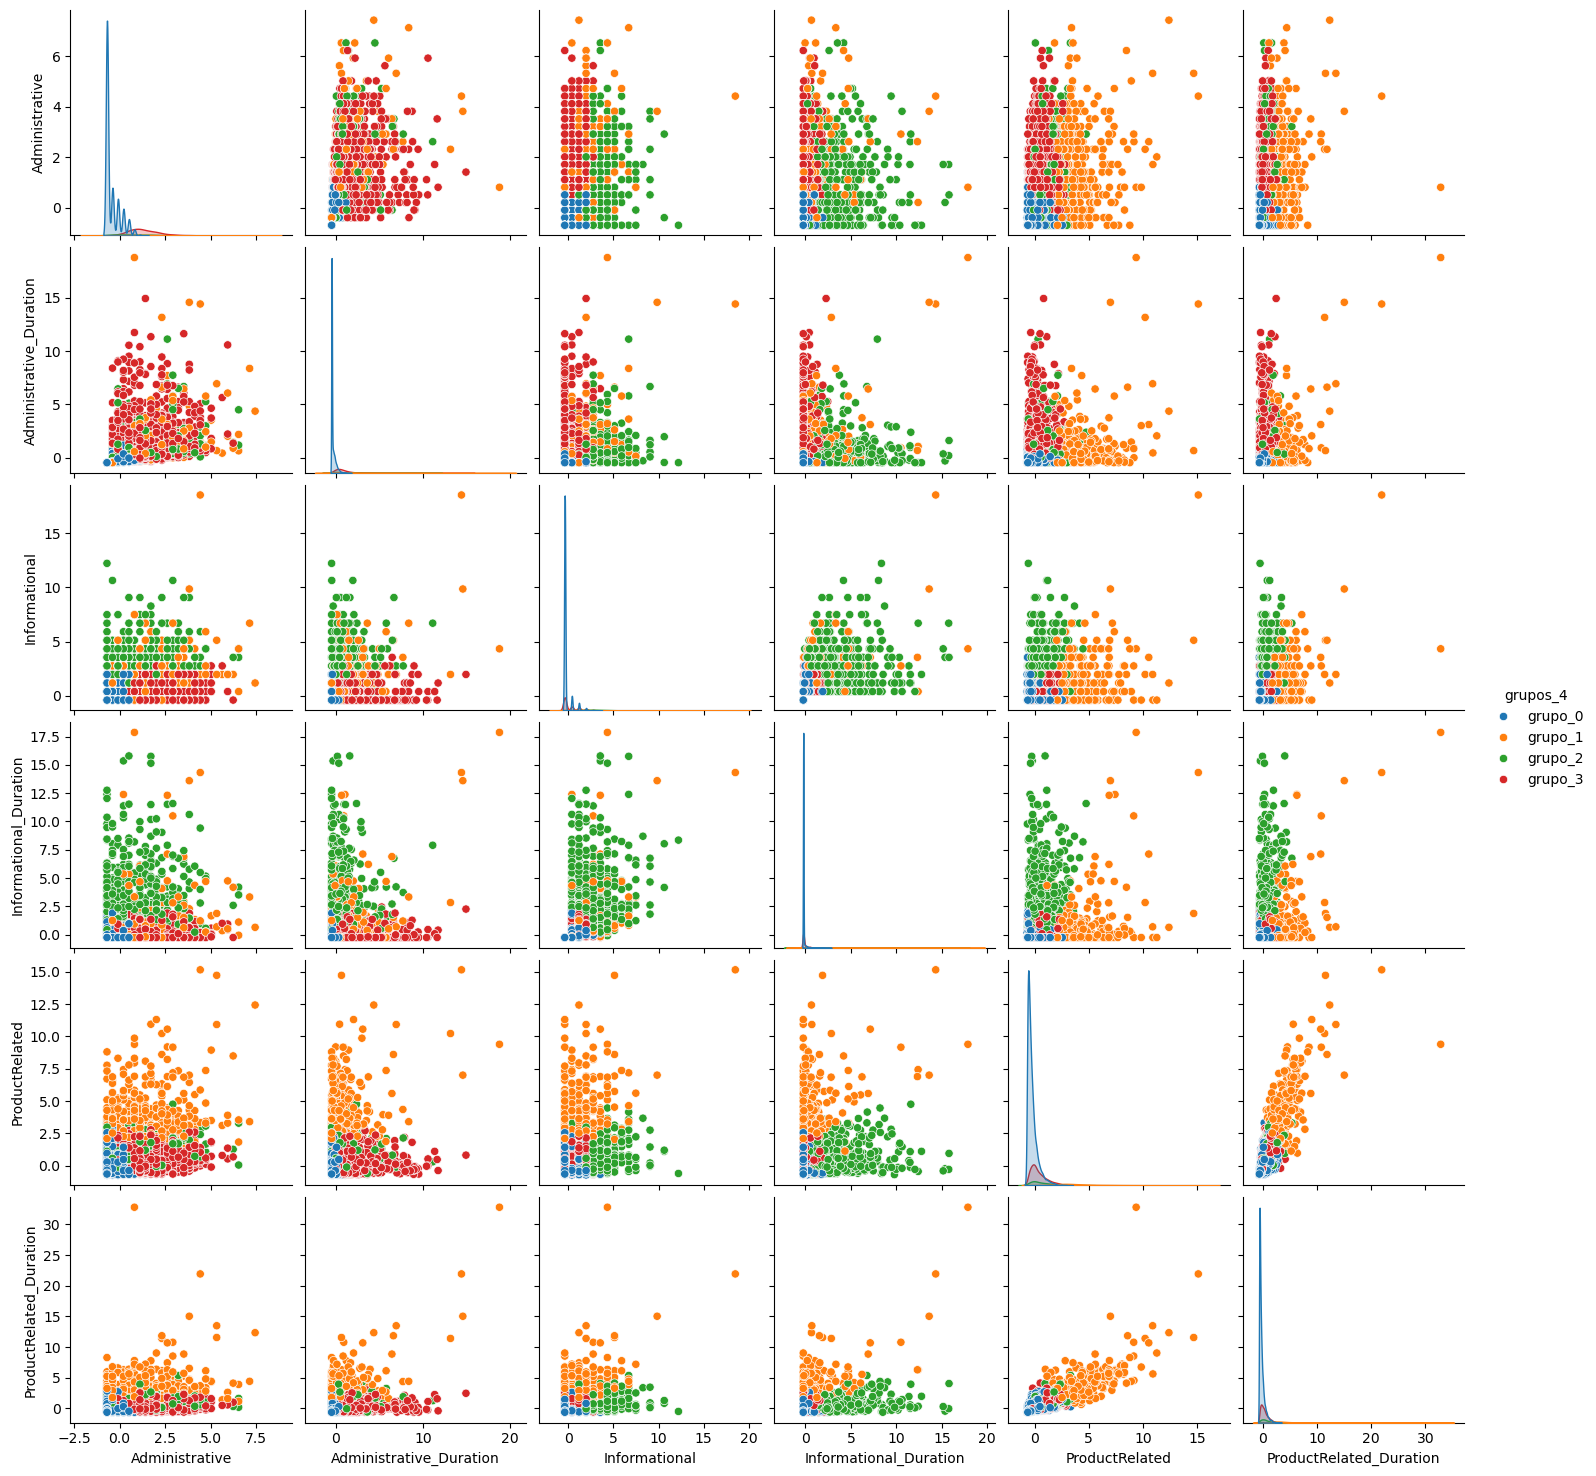

In [37]:
n_clusters = 4
var_grupo = 'grupos_' + str(n_clusters)
sns.pairplot(df_padronizado[colunas + [var_grupo]], hue=var_grupo)

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [38]:
df_padronizado['BounceRates'] = df_og['BounceRates']
df_padronizado.tail()

Administrative  Administrative_Duration  Informational  \
12325        0.206173                 0.363075      -0.396478   
12326       -0.696993                -0.457191      -0.396478   
12327       -0.696993                -0.457191      -0.396478   
12328        0.507228                -0.032916      -0.396478   
12329       -0.696993                -0.457191      -0.396478   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
12325               -0.244931        0.478227                 0.307822   
12326               -0.244931       -0.601062                -0.380957   
12327               -0.244931       -0.578577                -0.528063   
12328               -0.244931       -0.376210                -0.443536   
12329               -0.244931       -0.646033                -0.613243   

      grupos_2 grupos_3 grupos_4 grupos_5 grupos_6 grupos_7 grupos_8 grupos_9  \
12325  grupo_1  grupo_2  grupo_0  grupo_3  grupo_4  grupo_4  grupo_2  grupo_1   
12326  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
12327  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   
12328  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_1   
12329  grupo_1  grupo_2  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0  grupo_0   

      grupos_10  Revenue  BounceRates  
12325   grupo_0    False     0.007143  
12326   grupo_1    False     0.000000  
12327   grupo_1    False     0.083333  
12328   grupo_0    False     0.000000  
12329   grupo_1    False     0.000000

<Axes: xlabel='BounceRates', ylabel='grupos_4'>

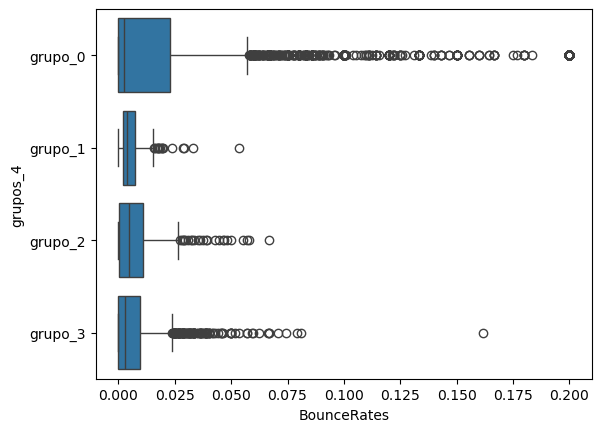

In [39]:
sns.boxplot(data=df_padronizado, y='grupos_4', x='BounceRates')

In [40]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_4'])

grupos_4  grupo_0  grupo_1  grupo_2  grupo_3
Revenue                                     
False        8091      243      404     1684
True         1161      128      148      471

In [41]:
pd.crosstab(df_padronizado['Revenue'], df_padronizado['grupos_4'], normalize='columns')

grupos_4   grupo_0   grupo_1   grupo_2   grupo_3
Revenue                                         
False     0.874514  0.654987  0.731884  0.781439
True      0.125486  0.345013  0.268116  0.218561

### R: Os clientes mais propensos à compra são do grupo_1 com 4 clusters, baseado na maior proporção e no menor percentual de visitantes que entram no site e saem sem acionar outros requests durante a sessão.